In [152]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from xlrd.xldate import xldate_as_datetime

from scipy.signal import find_peaks

Attached are three sets of data related to the marketing channel performance of a hypothetical business with similar seasonality to ours.  

In [82]:
df_1 = pd.read_csv("Data 1.csv")
df_2 = pd.read_csv("Data 2.csv")
df_3 = pd.read_csv("Data 3.csv")

#### Please review this information, and prepare the following: 

1) Analysis of the historical performance of the company and it's marketing efforts 

2) Recommendation of which channel(s) the company should focus on in the next year (2018) 

3) Cost and Revenue forecast for the entire company (all channels combined) by day for the two weeks leading up to Valentine's Day 2018 

4) Explanation of any assumptions you make, potential risks to your recommendations/analysis, and additional data you would want to look at to improve the accuracy of your analysis/recommendations 

#### Definitions: 

Date – Date the order was placed 

Channel – The marketing channel 

Sessions – The amount of traffic to the site 

Transactions – The order count 

Revenue – The association amount of money made. 

AOV – Average order volume 

CPA – Cost per acquisition (order) 

In [83]:
df_1.head()

,Date,Channel,Conversion Rate,Transactions,AOV,CPA
0,42404,Channel B,0.091545,1313,60.41,15
1,42401,Channel C,0.070204,936,64.96,8
2,42408,Channel D,0.153458,1885,69.67,18
3,42408,Channel C,0.185907,1653,66.36,7
4,42404,Channel D,0.129013,1113,68.35,19


In [84]:
df_2.head()

,Date,Channel,Sessions,Revenue,AOV,CPA
0,42735,Channel A,1377,19327,74.70,8
1,42735,Channel B,1161,8628,90.79,34
2,42735,Channel C,2409,15758,79.11,5
3,42735,Channel D,2563,15708,81.00,19
4,42734,Channel A,2416,37456,76.96,4


In [85]:
df_3.head()

,Date,Channel,Sessions,Transactions,AOV,CPA
0,12/31/2017,Channel A,1155,263,58.97,10
1,12/31/2017,Channel B,1311,108,72.06,27
2,12/31/2017,Channel C,1322,115,56.51,5
3,12/31/2017,Channel D,2320,198,63.71,14
4,12/30/2017,Channel A,1674,341,59.21,3


In [86]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156 entries, 0 to 155
Data columns (total 6 columns):
Date               156 non-null int64
Channel            156 non-null object
Conversion Rate    156 non-null float64
Transactions       156 non-null int64
AOV                156 non-null float64
CPA                156 non-null int64
dtypes: float64(2), int64(3), object(1)
memory usage: 7.4+ KB


In [87]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1308 entries, 0 to 1307
Data columns (total 6 columns):
Date        1308 non-null int64
Channel     1308 non-null object
Sessions    1308 non-null int64
Revenue     1308 non-null int64
AOV         1308 non-null float64
CPA         1308 non-null int64
dtypes: float64(1), int64(4), object(1)
memory usage: 61.4+ KB


In [88]:
df_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1400 entries, 0 to 1399
Data columns (total 6 columns):
Date            1400 non-null object
Channel         1400 non-null object
Sessions        1400 non-null int64
Transactions    1400 non-null int64
AOV             1400 non-null float64
CPA             1400 non-null int64
dtypes: float64(1), int64(3), object(2)
memory usage: 65.7+ KB


In [89]:
# Clean Date data format to datetime format for Data 1 and Data 2
df_1['Date'] = df_1.Date.apply(lambda x: xldate_as_datetime(x, 0))
df_2['Date'] = df_2.Date.apply(lambda x: xldate_as_datetime(x, 0))

# Generate new column, Cost, by multiplying AOV and CPA
df_1['cost'] = df_1['AOV'] * df_1['CPA']
df_2['cost'] = df_2['AOV'] * df_2['CPA']
df_3['cost'] = df_3['AOV'] * df_3['CPA']

# Analysis of the historical performance

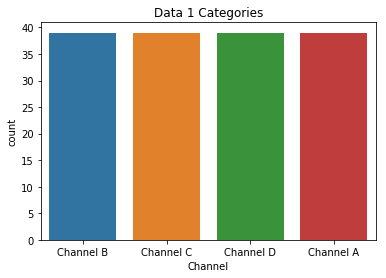

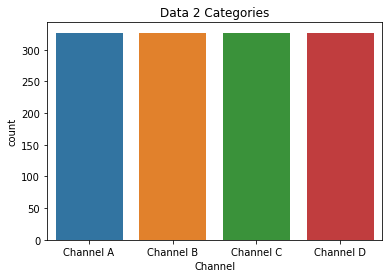

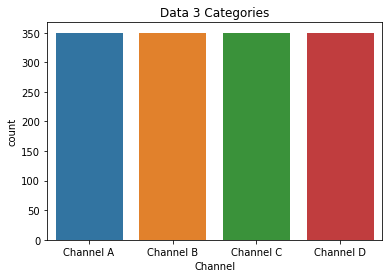

In [90]:
plt.title('Data 1 Categories')
sns.countplot(df_1.Channel)
plt.show()
plt.title('Data 2 Categories')
sns.countplot(df_2.Channel)
plt.show()
plt.title('Data 3 Categories')
sns.countplot(df_3.Channel)
plt.show()

In [91]:
# see if there is any missing dates in Datasets
for idx, df in enumerate(dfs):
    print('Data', idx + 1)
    print('# of Missing Dates:', len(pd.date_range(start = df.Date.values[0], 
                  end = df.Date.values[-1]).difference(pd.unique(df.Date.values))))
    print('Start Date:', str(df.Date.values[0])[:10])
    print('End Date:', str(df.Date.values[-1])[:10], '\n\n')

Data 1
# of Missing Dates: 0
Start Date: 2016-01-01
End Date: 2016-02-08 


Data 2
# of Missing Dates: 0
Start Date: 2016-02-09
End Date: 2016-12-31 


Data 3
# of Missing Dates: 237
Start Date: 1/16/2017
End Date: 9/9/2017 




Based on the above result, Data 1 and Data 2 have 

In [92]:
# Sort by time
dfs = [df_1, df_2, df_3]
for df in dfs:
    df.sort_values(by=['Date', 'Channel'], inplace=True)

In [93]:
def plot_channels(df, dataname):
    channels = ['Channel A', 'Channel B', 'Channel C', 'Channel D']
    time_data = []
    AOV_data = []
    CPA_data = []
    cost_data = []
    for channel in channels:
        temp = df_1[df_1.Channel == channel]
        time_data.append(temp.Date.values)
        AOV_data.append(temp.AOV.values)
        CPA_data.append(temp.CPA.values)
        cost_data.append(temp.cost.values)
        
    # plot time vs AOV for each channel
    plt.figure()
    plt.title('Time VS AOV ' + dataname)
    for i in range(len(channels)):
        plt.scatter(time_data[i], AOV_data[i])
    plt.legend(channels)
    plt.gcf().autofmt_xdate()
    plt.ylabel('Average order volume')
    plt.xlim(time_data[0][0], time_data[0][-1])
    plt.show()
    
    # plot time vs CPA for each channel
    plt.figure()
    plt.title('time vs CPA ' + dataname)
    for i in range(len(channels)):
        plt.scatter(time_data[i], CPA_data[i])
    plt.legend(channels)
    plt.ylabel('CPA – Cost per acquisition (order)')
    plt.gcf().autofmt_xdate()
    plt.xlim(time_data[0][0], time_data[0][-1])
    plt.show()
    
    # plot time vs AOV * CPA for each channel
    plt.figure()
    plt.title('time vs cost (AOV * CPA) ' + dataname)
    for i in range(len(channels)):
        plt.scatter(time_data[i], cost_data[i])
    plt.legend(channels)
    plt.ylabel('cost (CPA * AOV)')
    plt.gcf().autofmt_xdate()
    plt.xlim(time_data[0][0], time_data[0][-1])
    plt.show()

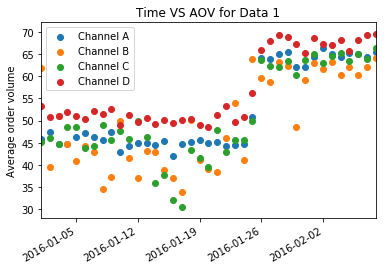

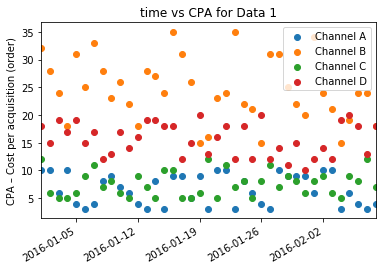

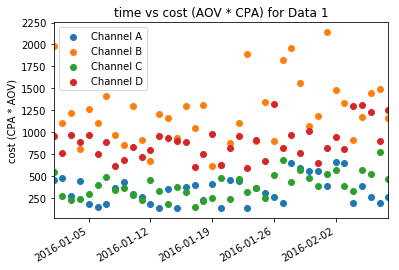

In [94]:
# Data 1
plot_channels(df_1, 'for Data 1')

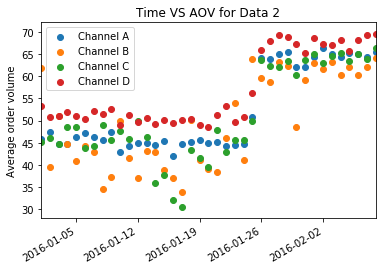

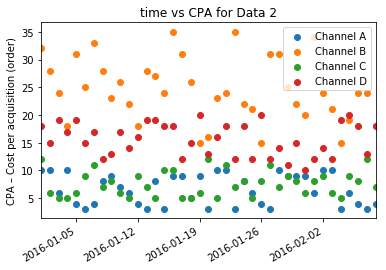

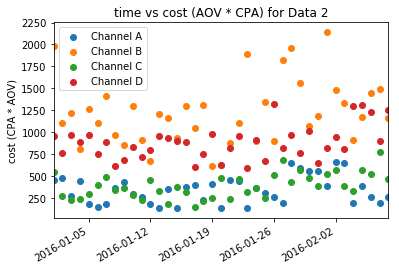

In [95]:
# Data 2
plot_channels(df_2, 'for Data 2')

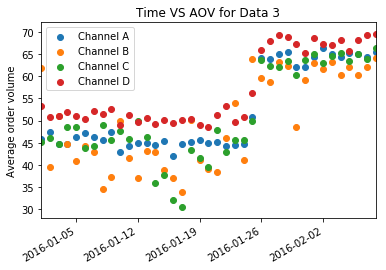

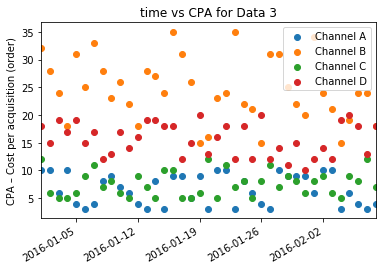

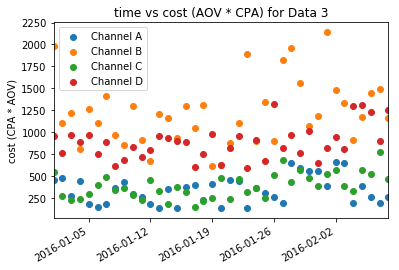

In [96]:
# Data 3
plot_channels(df_3, 'for Data 3')

### More Investigation into Data 1
Since each dataset contains different features, it is reasonable to investigate each data more intensely.

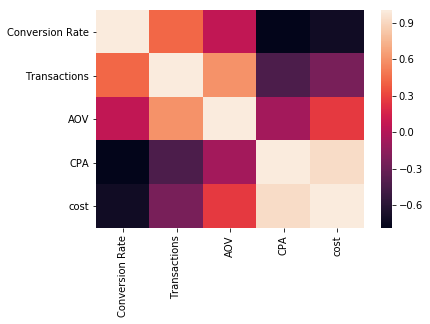

In [103]:
sns.heatmap(df_1.corr())

In [104]:
df_1.corr()

,Conversion Rate,Transactions,AOV,CPA,cost
Conversion Rate,1.000000,0.432564,0.059208,-0.786420,-0.705356
Transactions,0.432564,1.000000,0.595810,-0.424390,-0.238530
AOV,0.059208,0.595810,1.000000,-0.062885,0.261803
CPA,-0.786420,-0.424390,-0.062885,1.000000,0.927517
cost,-0.705356,-0.238530,0.261803,0.927517,1.000000


1) CPA and Conversion Rate have a negative correlation.

2) Transaction and CPA have an inverse correlation.

3) There is no/little correlation between AOV and Conversion Rate.

4) There is no/little correlation between AOV and CPA.

In [113]:
# generate corr map for each channel and see if there are different insights
def channel_corrmap(df):
    channels = ['Channel A', 'Channel B', 'Channel C', 'Channel D']
    
    for channel in channels:
        temp = df[df.Channel == channel]
        plt.title(channel)
        sns.heatmap(temp.corr())
        plt.show()

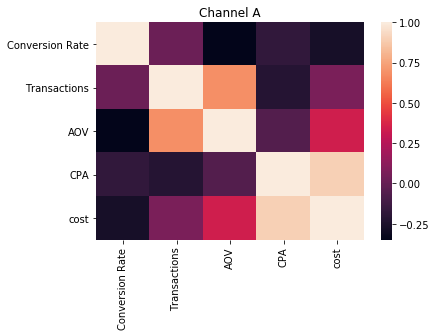

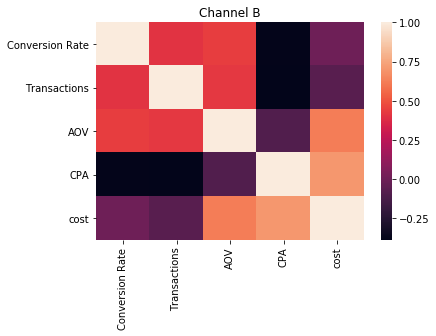

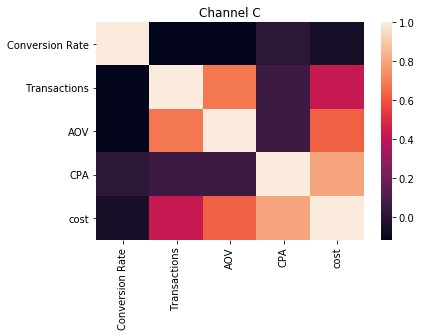

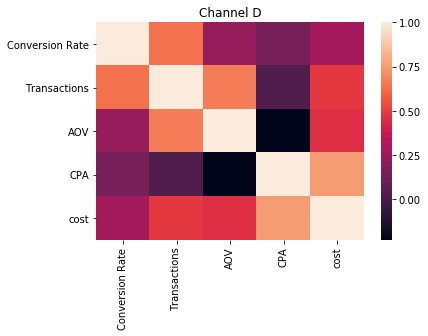

In [114]:
channel_corrmap(df_1)

After breaking down the correlation map for each channel, transactions and AOV are more closely correlated compared to other features. This makes sense becasue  the more people visit the site (AOV), the more transactions there should be. 

Channels A & C 

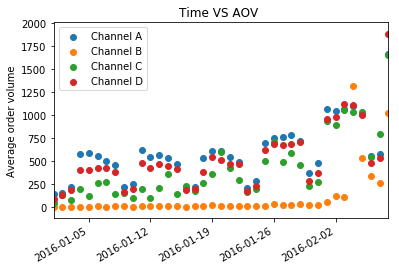

In [101]:
# transaction column
channels = ['Channel A', 'Channel B', 'Channel C', 'Channel D']

# plot time vs transaction for each channel
plt.figure()
plt.title('Time VS AOV ')
for channel in channels:
    temp = df_1[df_1.Channel == channel]
    plt.scatter(temp.Date.values, temp.Transactions.values)
plt.legend(channels)
plt.gcf().autofmt_xdate()
plt.ylabel('Average order volume')
plt.xlim(temp.Date.values[0], temp.Date.values[-1])
plt.show()

In [116]:
# To be continued
# The oscillation might be due to weekday vs weekend

# Adding day of week columns to the result


### More Investigation into Data 2

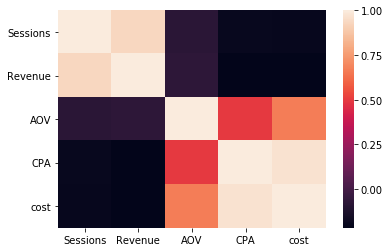

In [117]:
sns.heatmap(df_2.corr())

In [118]:
df_2.corr()

,Sessions,Revenue,AOV,CPA,cost
Sessions,1.000000,0.936695,-0.079046,-0.192785,-0.195390
Revenue,0.936695,1.000000,-0.070103,-0.216556,-0.212721
AOV,-0.079046,-0.070103,1.000000,0.498718,0.670985
CPA,-0.192785,-0.216556,0.498718,1.000000,0.971355
cost,-0.195390,-0.212721,0.670985,0.971355,1.000000


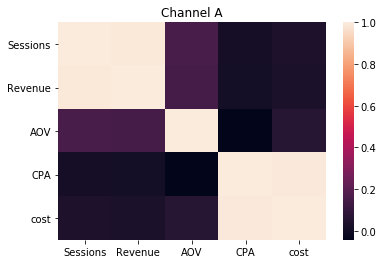

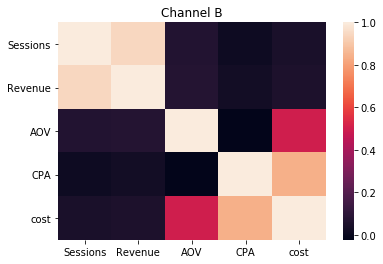

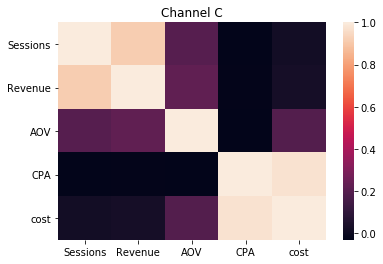

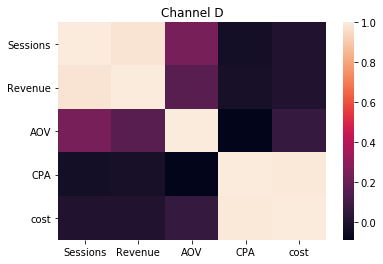

In [119]:
channel_corrmap(df_2)

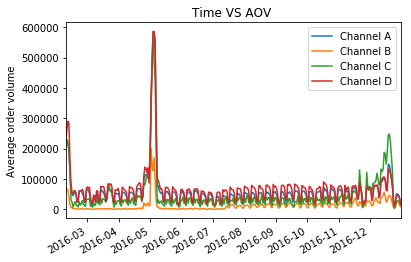

In [122]:
# Rvenue column
channels = ['Channel A', 'Channel B', 'Channel C', 'Channel D']

# plot time vs transaction for each channel
plt.figure()
plt.title('Time VS AOV ')
for channel in channels:
    temp = df_2[df_2.Channel == channel]
    plt.plot(temp.Date.values, temp.Revenue.values)
plt.legend(channels)
plt.gcf().autofmt_xdate()
plt.ylabel('Average order volume')
plt.xlim(temp.Date.values[0], temp.Date.values[-1])
plt.show()

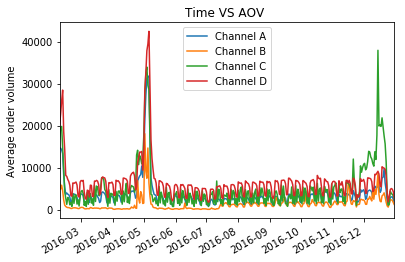

In [123]:
# Rvenue column
channels = ['Channel A', 'Channel B', 'Channel C', 'Channel D']

# plot time vs transaction for each channel
plt.figure()
plt.title('Time VS AOV ')
for channel in channels:
    temp = df_2[df_2.Channel == channel]
    plt.plot(temp.Date.values, temp.Sessions.values)
plt.legend(channels)
plt.gcf().autofmt_xdate()
plt.ylabel('Average order volume')
plt.xlim(temp.Date.values[0], temp.Date.values[-1])
plt.show()

Mother's Day and Valentines' Day

### More Investigation into Data 3

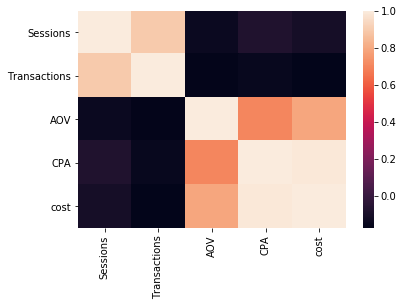

In [124]:
sns.heatmap(df_3.corr())

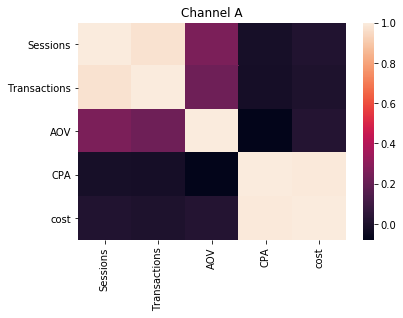

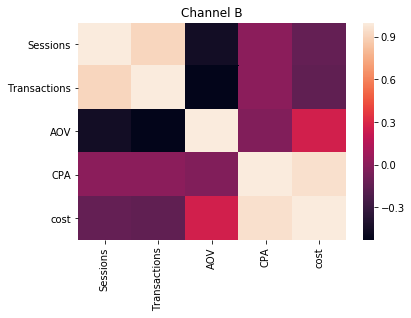

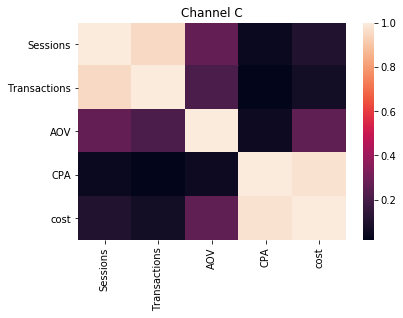

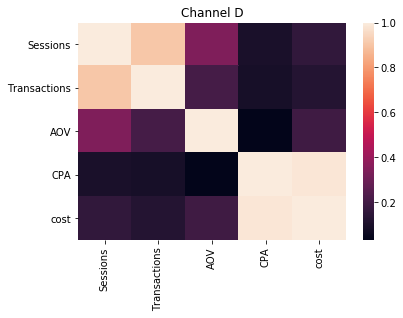

In [125]:
channel_corrmap(df_3)

## Recommendation of which channel(s) the company should focus on in the next year (2018)

## Cost and Revenue forecast for the entire company (all channels combined) by day for the two weeks leading up to Valentine's Day 2018

In [140]:
df_1_day = df_1.groupby('Date').sum()
df_1_day['Conversion Rate'] = df_1.groupby('Date')["Conversion Rate"].mean()

df_2_day = df_2.groupby('Date').sum()

df_3_day = df_3.groupby('Date').sum()

In [146]:
df_2_day.head()

,Sessions,Revenue,AOV,CPA,cost
Date,,,,,
2016-02-09,58179,717533,332.84,53,4358.71
2016-02-10,61768,783727,334.00,57,4765.19
2016-02-11,65640,792780,344.13,71,6117.76
2016-02-12,61124,719074,370.59,46,4190.59
2016-02-13,38956,434234,382.39,42,3916.51


Since we don't have enough data to predict 

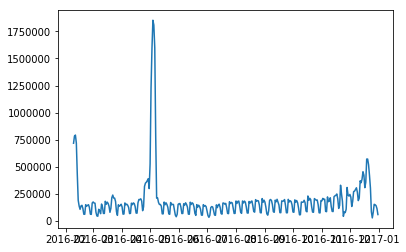

In [150]:
plt.figure()
plt.plot(df_2_day.index.values, df_2_day.Revenue.values)
plt.show()

In [156]:
index = find_peaks(df_2_day.Revenue.values)

In [186]:
df_2_day.iloc[index[0].tolist()]

,Sessions,Revenue,AOV,CPA,cost
Date,,,,,
2016-02-11,65640,792780,344.13,71,6117.76
2016-02-18,13220,144715,323.59,68,5526.02
2016-02-22,14305,150325,305.73,63,4947.03
2016-02-25,13740,150345,322.68,63,5120.21
2016-03-01,15494,175643,312.66,41,3275.79
2016-03-07,11084,107926,298.74,49,3683.79
2016-03-10,13192,156339,320.04,43,3478.26
2016-03-14,16505,181804,290.77,39,2819.73
2016-03-16,16425,174515,311.68,56,4516.83
